In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input




In [ ]:
data_gen = ImageDataGenerator(rescale=1.0/255)


In [ ]:
imgdir = 'a5_images' # or wherever you put them...
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/a5_images/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [ ]:
Xbatch, Ybatch = train_generator.next()

In [ ]:
Xbatch.shape

(32, 64, 64, 3)

In [ ]:
Ybatch[6]

0.0

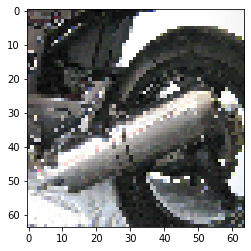

In [ ]:
plt.imshow(Xbatch[6]);


## Part 1

The function *make_convnet()* aims to create a CNN network with 1 input layer, 5 hidden layers and 1 output layers. The optimizer used is stochastic gradient descent. All hyperparameters could be tuned here, but due to the large amount of time needed, this has not been done more than on intuition.

In [ ]:
#Function that will return a CNN network.
def make_convnet(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
#Declaring constants
imgdir = 'a5_images'
img_size = 64
batch_size = 32

#Creating the validation generator
validation_generator = data_gen.flow_from_directory(
        imgdir + '/a5_images/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Xval, Yval = validation_generator.next()

Found 576 images belonging to 2 classes.


In [ ]:
input_shape = Xbatch[1].shape
model = make_convnet(input_shape)

epochs = 10

#Training and validating the model
fit_info = model.fit(train_generator,
epochs=epochs,
verbose=1,
validation_data=validation_generator)


Epoch 1/10
/shared-libs/python3.7/py/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
50/50 [==============================] - 18s 337ms/step - loss: 0.6793 - accuracy: 0.5644 - val_loss: 0.6705 - val_accuracy: 0.5330
Epoch 2/10
50/50 [==============================] - 16s 323ms/step - loss: 0.6383 - accuracy: 0.6350 - val_loss: 0.7345 - val_accuracy: 0.5851
Epoch 3/10
50/50 [==============================] - 16s 318ms/step - loss: 0.5667 - accuracy: 0.7269 - val_loss: 0.5923 - val_accuracy: 0.6979
Epoch 4/10
50/50 [==============================] - 16s 322ms/step - loss: 0.5349 - accuracy: 0.7387 - val_loss: 0.6087 - val_accuracy: 0.7153
Epoch 5/10
50/50 [==============================] - 16s 316ms/step - loss: 0.5236 - accuracy: 0.7487 - val_loss: 0.5668 - val_accuracy: 0.6944
Epoch 6/10
50/50 [==============================] - 16s 323ms/step -

In [ ]:
model.load_weights('cnn_model')
model.evaluate(validation_generator, verbose=0)

[0.5580493807792664, 0.7586805820465088]

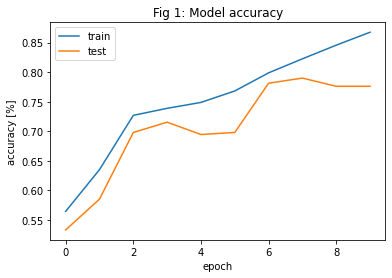

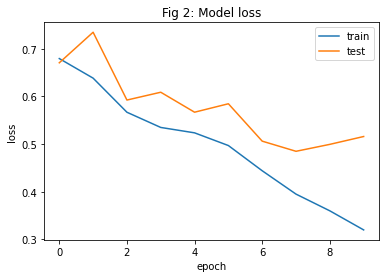

In [ ]:
'''
The following code only works if the model was trained and not loaded previously.
'''
plt.plot(fit_info.history['accuracy'])
plt.plot(fit_info.history['val_accuracy'])
plt.title('Fig 1: Model accuracy')
plt.ylabel('accuracy [%]')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_plot.png')
plt.show()

plt.plot(fit_info.history['loss'])
plt.plot(fit_info.history['val_loss'])
plt.title('Fig 2: Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss_plot.png')
plt.show()

As we can see in Fig 1 the accuracy is rising when number of epochs is rising. Although, after 7-8 epochs it seems like the accuracy is declining for the test set. This is due to overfitting on the training set. This is also shown in Fig 2, showing the loss of the model. While the training loss is constantly decreasing, the test loss is increasing after around 6 epochs.

There are many reasons why the model is overfitting (low amount of data, bad design in the CNN model) and many solutions to prevent it. One could be to change the architecture of the model and adding some dropout layers. Another approach could be to increase and change the data set. This is done in Part 2 below.

### Part 2 - Data Augmentation

The approach to increase and change the data set is done by adding augmentation to the images. Augmentations could for example be: rescaling, rotations or shearing.

Found 1600 images belonging to 2 classes.


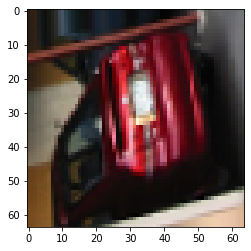

In [ ]:
data_gen_aug = ImageDataGenerator(
    rescale = 1.0/255, 
    rotation_range = 360,
    shear_range = 50.0,
    zca_whitening = False)

train_generator = data_gen_aug.flow_from_directory(
        imgdir + '/a5_images/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Xbatch, Ybatch = train_generator.next()
plt.imshow(Xbatch[1]);

The image above shows one of the pictures both being rotated and somewhat sheared

We continue and fit a similar model to the new augmented data:

In [ ]:
model = make_convnet(input_shape)

epochs = 15
#Training and validating the model

fit_info = model.fit(train_generator,
#batch_size=batch_size,
epochs=epochs,
verbose=1,
validation_data=validation_generator)

Epoch 1/15
50/50 [==============================] - 20s 385ms/step - loss: 0.6909 - accuracy: 0.5281 - val_loss: 0.6861 - val_accuracy: 0.5000
Epoch 2/15
50/50 [==============================] - 18s 361ms/step - loss: 0.6675 - accuracy: 0.6125 - val_loss: 0.6803 - val_accuracy: 0.5885
Epoch 3/15
50/50 [==============================] - 18s 363ms/step - loss: 0.6496 - accuracy: 0.6206 - val_loss: 0.6359 - val_accuracy: 0.6632
Epoch 4/15
50/50 [==============================] - 18s 369ms/step - loss: 0.6440 - accuracy: 0.6350 - val_loss: 0.6651 - val_accuracy: 0.6146
Epoch 5/15
50/50 [==============================] - 18s 356ms/step - loss: 0.6463 - accuracy: 0.6444 - val_loss: 0.6658 - val_accuracy: 0.6319
Epoch 6/15
50/50 [==============================] - 18s 359ms/step - loss: 0.6305 - accuracy: 0.6388 - val_loss: 0.6374 - val_accuracy: 0.6354
Epoch 7/15
50/50 [==============================] - 18s 364ms/step - loss: 0.6267 - accuracy: 0.6500 - val_loss: 0.6301 - val_accuracy: 0.6719

In [ ]:
model.load_weights('cnn_model_aug')
model.evaluate(validation_generator, verbose=0)

[0.5976908802986145, 0.6753472089767456]

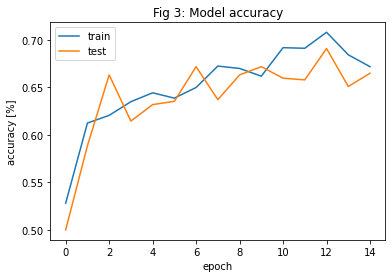

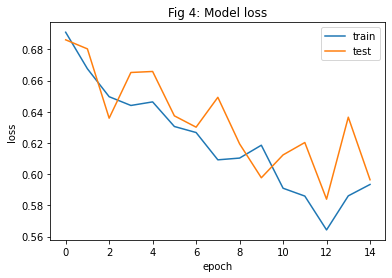

In [ ]:
'''
The following code only works if the model was trained and not loaded previously.
'''
plt.plot(fit_info.history['accuracy'])
plt.plot(fit_info.history['val_accuracy'])
plt.title('Fig 3: Model accuracy')
plt.ylabel('accuracy [%]')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_plot_aug.png')
plt.show()

plt.plot(fit_info.history['loss'])
plt.plot(fit_info.history['val_loss'])
plt.title('Fig 4: Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss_plot_aug.png')
plt.show()

When doing data augmentations Fig 3 and Fig 4 shows that the overfitting is not present. Altough, there seem to be more fluctuations on both the accuracy and loss. This is why we cant say exactly that overfitting is happening in the last epoch for the accuracy. If we would train for even more epochs, the graph may very well looked jagged again. The jagged graph is due to the small size of the validation set. Before choosing a epoch-constant for training the model on, we should probably try it many times so we do not end up in a local minimum (epoch 6) and having bad performance on our model.




## Interlude

In this section, VGG-16 model used with the pre-trained weights for imagenet, and applied on the given dataset. 

In [ ]:
vggmodel = applications.VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 2s 0us/step


0.0


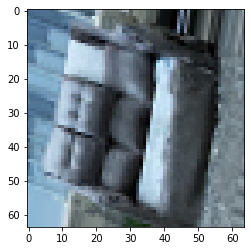

In [ ]:
plt.imshow(Xbatch[12])
print(Ybatch[12])

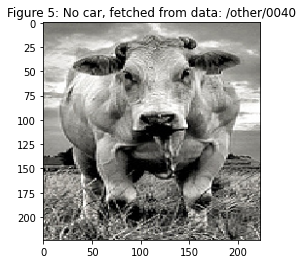

49152/35363 [=========================================] - 0s 0us/step
Prediction of other/0040 [[('n02408429', 'water_buffalo', 0.25510597), ('n02398521', 'hippopotamus', 0.18484354), ('n02403003', 'ox', 0.17186956), ('n02397096', 'warthog', 0.1512155), ('n02395406', 'hog', 0.084864914)]]


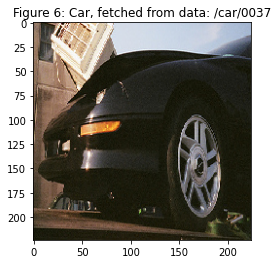

Prediction of car/0037 [[('n04461696', 'tow_truck', 0.13490468), ('n03770679', 'minivan', 0.068477325), ('n04009552', 'projector', 0.0675047), ('n03670208', 'limousine', 0.06740151), ('n02974003', 'car_wheel', 0.060940117)]]


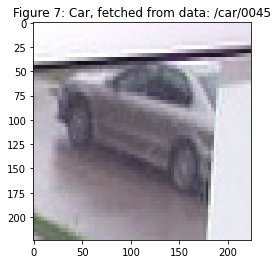

Prediction of car/0045 [[('n03924679', 'photocopier', 0.165615), ('n04239074', 'sliding_door', 0.15867321), ('n04070727', 'refrigerator', 0.13440697), ('n03207941', 'dishwasher', 0.12357506), ('n03776460', 'mobile_home', 0.09824556)]]


In [ ]:
#0037
#0040
#0045
#0047
img = load_img('a5_images/a5_images/train/other/0040.jpg', target_size=(224,224))
plt.imshow(img)
plt.title('Figure 5: No car, fetched from data: /other/0040')
plt.show()

img_arr = img_to_array(img)
img_proc = preprocess_input(img_arr)
img_reshape = img_proc.reshape(1, 224, 224 ,3)

print('Prediction of other/0040' , decode_predictions(vggmodel.predict(img_reshape)))

img = load_img('a5_images/a5_images/train/car/0037.jpg', target_size=(224,224))
plt.imshow(img)
plt.title('Figure 6: Car, fetched from data: /car/0037')
plt.show()

img_arr = img_to_array(img)
img_proc = preprocess_input(img_arr)
img_reshape = img_proc.reshape(1, 224, 224 ,3)

print('Prediction of car/0037', decode_predictions(vggmodel.predict(img_reshape)))

img = load_img('a5_images/a5_images/train/car/0045.jpg', target_size=(224,224))
plt.imshow(img)
plt.title('Figure 7: Car, fetched from data: /car/0045')
plt.show()

img_arr = img_to_array(img)
img_proc = preprocess_input(img_arr)
img_reshape = img_proc.reshape(1, 224, 224 ,3)

print('Prediction of car/0045', decode_predictions(vggmodel.predict(img_reshape)))


Applying the VGG-16 model on the given dataset, the classifications are more in detail than the two classes which the dataset is divided into. 

Three examples of predictions are shown above. Figure 5, is clearly no car. This image is predicted as some different animals, with water buffalo having the highest probability which seems correct. 

In Figure 6, the back of a car is shown. This is predicted as a tow_truck, minivan and a projector as the top three predictions. The first two are a kind of car, but even if the predictions are more exact than "car", it is the wrong kind of car that is suggested. Projector is incorrect. 

Figure 7 also shows a car. This is predicted as "photocopier", "sliding door" and "refrigerator" as the top three, which are all incorrect predictions. 

The reason to why the predictions are somewhat off could be because the model has not been exposed to these kinds of images while training but to imagenet. If imagenet contains of more clear object images, the model will have some trouble classifying parts of objects as the correct one. Even if imagenet consists of very many images, the goal has not been to classify cars but to many different objects and the model is therefore not the most suitible one for this task. Instead, which will be seen in part 3, some adjustments needs to be made to the model, exposing and training it on the given dataset, to be able to improve performance. 


## Part 3
To train a model to classify cars, VGG-16 can be used as a pre-trained model but modified. The first layers of this model will be used to extract features of the images, but a new top layer is added and trained to determine appropriate weights. By setting include_top = False, the top layer is removed from the VGG-16 model and is stored in feature_extractor.

In [ ]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))


def create_vgg16_features(file_path, save_to_file, img_size, batch_size):

    vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    generator = vgg_data_gen.flow_from_directory(
        file_path,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        #class_mode='binary',
        #classes=['other', 'car'],
        seed=12345,
        shuffle=False)

    cnn_features = feature_extractor.predict(generator)

    with open(save_to_file, 'wb') as f:
        np.save(f, cnn_features)


create_vgg16_features('a5_images/a5_images/train', 'train_file', 64, 32)
create_vgg16_features('a5_images/a5_images/validation', 'val_file', 64, 32)

58900480/58889256 [==============================] - 0s 0us/step
Found 1600 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [ ]:
def transfer_cnn():
    #feature_extractor.trainable = False
    model = Sequential()
    #model.add(feature_extractor)
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))

def train_on_cnnfeatures():

    #Reading the data
    with open("train_file", 'rb') as f:
        train_data = np.load(f)
    with open("val_file", 'rb') as f:
        val_data = np.load(f)

    #Training the data
    model = transfer_cnn()

    #Changing labels
    y_train = get_labels(len(train_data))
    y_val = get_labels(len(val_data))

    #Fitting the data
    VGG16_fit_info = model.fit(train_data,y_train,
        #batch_size=batch_size,
        epochs=epochs,
        verbose=1, 
        validation_data=(val_data,y_val))

    return VGG16_fit_info, model

In [ ]:
epochs = 15

history, model = train_on_cnnfeatures()

Epoch 1/15
50/50 [==============================] - 1s 5ms/step - loss: 1.1930 - accuracy: 0.8144 - val_loss: 0.5385 - val_accuracy: 0.8715
Epoch 2/15
50/50 [==============================] - 0s 3ms/step - loss: 0.2112 - accuracy: 0.9369 - val_loss: 0.5416 - val_accuracy: 0.8785
Epoch 3/15
50/50 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.9844 - val_loss: 0.5452 - val_accuracy: 0.8802
Epoch 4/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0110 - accuracy: 0.9994 - val_loss: 0.5701 - val_accuracy: 0.8802
Epoch 5/15
50/50 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.5446 - val_accuracy: 0.8750
Epoch 6/15
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6015 - val_accuracy: 0.8837
Epoch 7/15
50/50 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5975 - val_accuracy: 0.8837
Epoch 8/15
50/50 [==

This time the validation accuracy is at 88% significantly higher than the previous 67%. As discussed above, a reason for the previous low accuracy is due to the fact that the dataset is small. Hence, it is not able to get enough information to understand the specific shapes and curves that it finds. However, when utilizing an already pre-trained part of the model that has been trained on a larger dataset the basic shaped and curves have already been established there, which enables it to focus more on how to differentiate the different picture as cars or not, instead of firstly creating a basic pattern understanding.

## Part 4

In the final part, we are supposed to visualize the intial layers patterns. Since these are the first layers, we expect to find low level patterns which for us will probably be hard to infere something from.

In [ ]:
first_layer_weights = vggmodel.get_weights()[0]
first_layer_weights.shape
#print(vggmodel.summary())

(3, 3, 3, 64)

In [ ]:
def kernel_image(weights, i, positive):
    
    # extract the convolutional kernel at position i
    k = weights[:,:,:,i].copy()
    if not positive:
        k = -k
    
    # clip the values: if we're looking for positive
    # values, just keep the positive part; vice versa
    # for the negative values.
    k *= k > 0

    # rescale the colors, to make the images less dark
    m = k.max()
    if m > 1e-3:
        k /= m 

    return k

### Positive patterns 1-64:

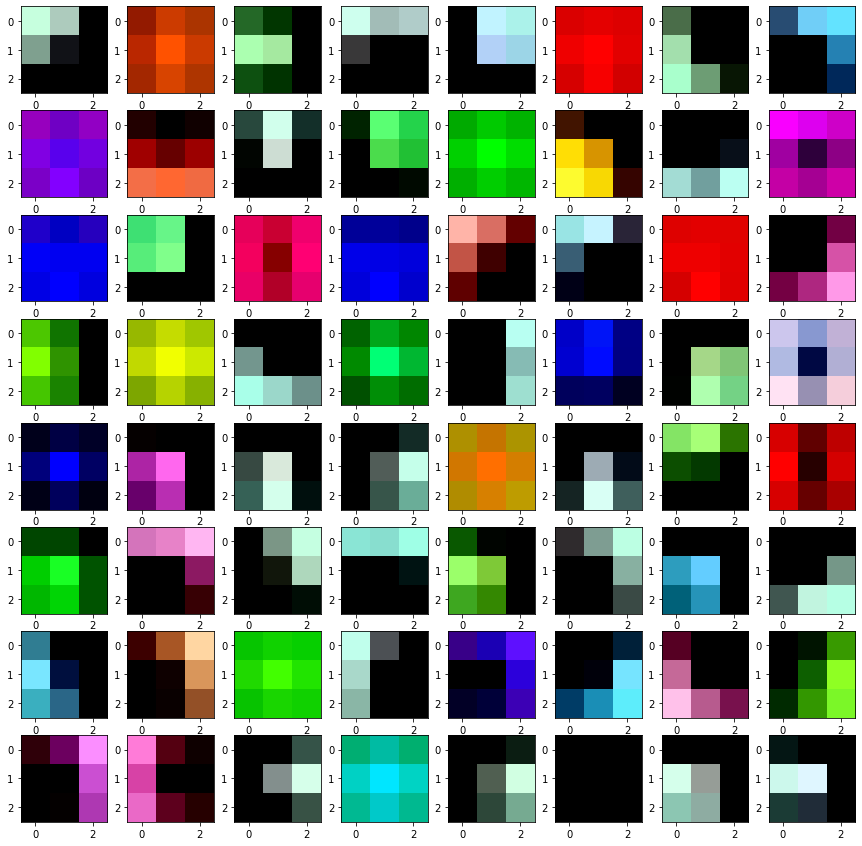

In [ ]:
fig = plt.figure(figsize=(15, 15))

for i in range(64):
    img = kernel_image(first_layer_weights, i, True)
    fig.add_subplot(8,8, i+1)
    plt.imshow(img)
    i+=1
    

### Negative patterns 1-64:

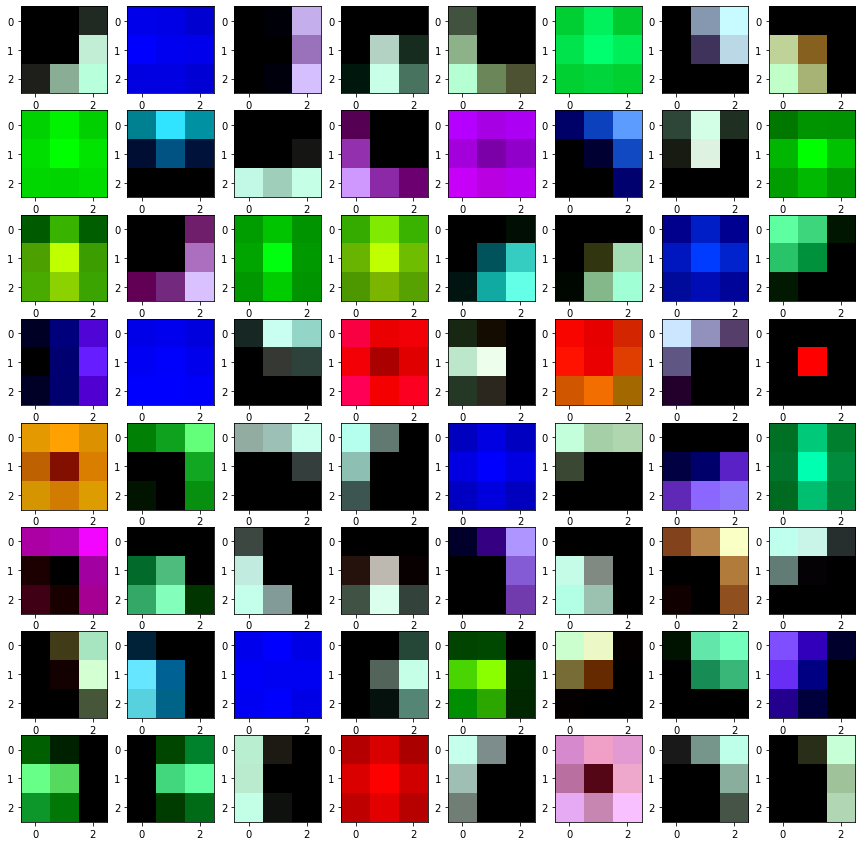

In [ ]:
fig = plt.figure(figsize=(15, 15))

for i in range(64):
    img = kernel_image(first_layer_weights, i, False)
    fig.add_subplot(8,8, i+1)
    plt.imshow(img)
    i+=1

As expected the images above shows that we found very low level patterns, making it hard to distinguish anything meaningful. As expected, the corresponding positive and negative subplot is somewhat opposit in light and dark colors.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b26cb8d9-dce0-4de1-ba19-c3098e02fffd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>